<a href="https://colab.research.google.com/github/CristianICS/UIMP-2023-keynotes/blob/main/pretratamiento_wv3_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pretratamiento de una imagen WV3

Las bandas de una imagen WV3 están recogidas en el siguiente orden:

- Coastal
- Blue
- Green
- Yellow
- Red
- RedEdge
- N1
- N2

In [ ]:
# !pip list command # Comprobar paquetes instalados en Google Colab
!pip install rasterio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.1 MB/s eta 0:00:00


In [ ]:
# Download images from Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root = "gdrive/My Drive/UIMP"

Mounted at /content/gdrive


In [ ]:
# Importar modulos
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

El tratamiento de la imagen con Python se realiza con las funciones de GDAL.

- Mantiene los metadatos del archivo GEOTiff
- Permite la transformación de coordenadas
- Convierte las imágenes a matrices (numpy data frames)

Nota: GDAL viene instalado en Google Colab (v. 3.4.3). Para una instalación manual seguir las [instrucciones incluidas en la web del proyecto.](https://pypi.org/project/GDAL/).

In [ ]:
from osgeo import gdal

def raster2nparray(input_ras):
    """
    Return a numpy array plus raster properties from an input raster
    ===================================================================

    :param input_ras: Input Raster
    :return: NumPy array from a Raster; single or multi-band and other raster
    properties such as originX, originY, cellSize, spatial reference & NoDataValue
    """
    # Open input raster data and get properties
    raster_obj = gdal.Open(input_ras)
    geotransform = raster_obj.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    cellsize = geotransform[1]
    spatialref = raster_obj.GetSpatialRef()

    num_bands = raster_obj.RasterCount
    num_cols = raster_obj.RasterXSize
    num_rows = raster_obj.RasterYSize

    # Transform raster into numpy array
    # Create an empty matrix in which store image bands
    nparray = np.empty([num_bands, num_rows, num_cols])
    ndvals = [] # List to append nodatavalues by band

    # Get all bands
    for band in range(num_bands):
        raster_band = raster_obj.GetRasterBand(band+1)
        # Read cells as a numpy array
        nparray[band,:,:] = raster_band.ReadAsArray()
        # Get the NoData value
        ndvals.append(raster_band.GetNoDataValue())

    return nparray, originX, originY, cellsize, spatialref, ndvals

# Define a function that
def nparray2ras(nparray, outRasterPath, cellSize, rasterOrigin, spRef, ndVals):
    """
    Create an output raster at a specified path from an input numpy array and raster properties
    ============================================================================

    :param nparray: Input NumPy Array
    :param outRasterPath: Output raster Path
    :param cellSize: Output raster cell size
    :param rasterOrigin: Output raster origin as a list with [X, Y] coord values
    :param spRef: Output raster spatial reference
    :return: None
    """

    # Start creating the output raster and write to it
    gdalDriver = gdal.GetDriverByName('GTiff')
    output_raster = gdalDriver.Create(outRasterPath, nparray.shape[2], nparray.shape[1], nparray.shape[0], gdal.GDT_Float32)
    output_raster.SetGeoTransform((rasterOrigin[0], cellSize, 0, rasterOrigin[1], 0, -cellSize))
    # Write data by band
    for band in range(output_raster.RasterCount):
        output_band = output_raster.GetRasterBand(band+1)
        output_band.WriteArray(nparray[band, :, :])
        output_band.SetNoDataValue(ndVals[band])
    # Set projection
    output_raster.SetProjection(spRef.ExportToWkt())
    # Finish export and remove cache
    output_raster.FlushCache()

# Acotar valores automaticamente
def normalize(arr, max = 1):
  # arr *= max/arr.max()
  arr = (arr - arr.min()) / (arr.max() - arr.min())
  return arr

## Comprobar la imagen original

Se lee como una matriz de tres dimensiones:

- 8 Bandas
- 657 px de alto (filas)
- 938 px de ancho (columnas)

In [ ]:
img_src = root + '/images/wv3_17MAY29.tif'

# Leer la imagen original como una matriz
raw_img = raster2nparray(img_src)[0]

print('\nDimensiones (bandas * filas * columnas): {}'.format(raw_img.shape))


Dimensiones (bandas * filas * columnas): (8, 657, 938)


Se pueden representar las bandas por separado (e.g. la banda del rojo)

Nota: La selección de las bandas se realiza a través de sus índices, teniendo en cuenta que en Python la numeración comienza desde el 0 (e.g. la banda del rojo es la 5a, y se selecciona mediante el índice 4 en la matriz).

Text(0, 0.5, 'Row #')

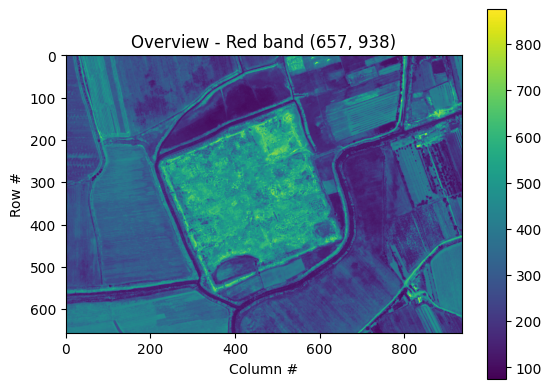

In [ ]:
# Representar una de sus bandas
plt.imshow(raw_img[4, :, :])
plt.colorbar()
plt.title('Overview - Red band {}'.format(raw_img[5, :, :].shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

También se puede representar una imagen en color especificando los tres canales:

- Rojo
- Verde
- Azul

Nota: Es necesario transformar las dimensiones de la matriz para poder representarla con `matplotlib`. Se utiliza la función `transpose`.  


In [ ]:
# Seleccionar las bandas del Rojo, Verde y Azul
rgb = raw_img[[4,2,1]].transpose(1,2,0)
print('Dimensiones de la imagen original:', raw_img.shape)
print('Dimensiones RGB:', rgb.shape)

Dimensiones de la imagen original: (8, 657, 938)
Dimensiones RGB: (657, 938, 3)


Text(0, 0.5, 'Row #')

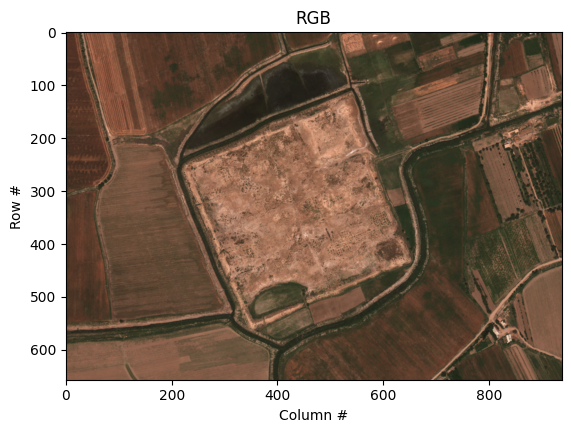

In [ ]:
# Acotar valores para su representacion
plt.imshow(np.clip(rgb/800, 0 ,800))
plt.title('RGB')
plt.xlabel('Column #')
plt.ylabel('Row #')

## Asignar coordenadas / Georreferenciar

La mayoría de imágenes de satélite están georreferenciadas, i.e., cuentan con un sistema de coordenadas que las localiza en el espacio. Sin embargo, algunos productos no cuentan con esta corrección (e.g. imágenes CORONA).

Es recomendable georreferenciar manualmente estas imágenes, pues es la base para relacionar su información con diferentes productos cartográficos dentro de un SIG.

En mi caso, he utilizado el [pluggin Georreferencer](https://docs.qgis.org/3.28/en/docs/user_manual/working_with_raster/georeferencer.html) de QGIS para realizar este trabajo.

![Georreferenciación de un mapa antiguo en base a las cuadrículas UTM.](https://github.com/CristianICS/UIMP-keynotes/blob/main/georreferencer_window.png?raw=1)

## Transformar los valores a reflectividad / Corrección radiométrica

Los datos de las imágenes están expresados en *relative radiometrically corrected image pixels*, i.e., Niveles Digitales (ND). Esta es la unidad en la que se descargan la mayoría de productos de teledetección (a no ser que integren algún tratamiento de corrección).

> Spacecraft use a string of 8 binary numbers (called 8-bit data), which can range from 00000000 to 11111111. These numbers correspond from 0 to 255 in the decimal system. (Kuchkorov et al., 2020)

El motivo de este sistema de almacenamiento es evitar altos contrastes dentro de la imagen y reducir el tamaño de la misma.

Los NDs representan la cantidad de radiancia espectral captada por el sensor y transformada en señal digital. Son datos específicos de cada sensor: **no deben ser directamente comparados con otros sensores**.



In [ ]:
# Niveles digitales de la banda del rojo
print(raw_img[4,:,:])

[[244. 243. 243. ... 406. 409. 412.]
 [245. 244. 245. ... 393. 403. 416.]
 [252. 247. 244. ... 396. 408. 408.]
 ...
 [439. 439. 435. ... 164. 168. 175.]
 [439. 432. 429. ... 170. 163. 184.]
 [449. 442. 430. ... 175. 170. 183.]]


Es necesario transformar los ND en valores de **reflectividad**. Es la unidad relativa en la que se expresa la radiación reflejada por una superficie (valores entre 0 y 1).

### De ND a Radiancia

El primer paso es la calibracíon radiométrica o *Absolute Radiometric Calibration* (ARC). Devuelve valores de radiancia, valor que indica el grado de potencia emitida, reflejada, transmitida o recibida por una superficie. Además, al aplicar la ARC se normalizan los píxeles del sensor entorno a un valor de referencia, evitando posibles distorsiones provocadas por la utilización de más de un sensor para tomar las imágenes.

![Efecto de la calibración radiométrica en una imágen de satélite (sensor Göktürk-2). Imagen RAW (arriba) y corregida (abajo) (Mustafa Teke, 2016, p. 4)](https://github.com/CristianICS/UIMP-keynotes/blob/main/arc_correction_effects.png?raw=1)

> **Importante**: La fórmula de la ARC es específica para cada sensor. Es necesario [consultar su ficha técnica](https://dg-cms-uploads-production.s3.amazonaws.com/uploads/document/file/207/Radiometric_Use_of_WorldView-3_v2.pdf).

La fórmula de la ARC para WV3 es la siguiente:

$L = GAIN \cdot DN \cdot ( a / e ) + OFFSET$

donde:

- $L$: Valores de radiancia
- $DN$: Píxeles originales en niveles digitales
- $GAIN$: Ganancia
- $OFFSET$: Sesgo o constante
- $a$ = *abscalfactor*
- $e$ = *effectivebandwith*

Todos estos valores se pueden encontrar en la ficha técnica del sensor, y los valores de $a$ y $e$ en los metadatos de la imágen (son específicos de cada banda).

In [ ]:
# Absolute radiometric Calibration Adjustment Factors for WorldView-3
adj_factors = {
    'B': {
        'GAIN': 0.905,
        'OFFSET': -4.189,
        'absCalFactor': 1.772364e-02,
        'effectiveBandwidth': 5.400000e-02,
        'E_Thuillier': 2004.61
    },
    'G': {'GAIN': 0.907, 'OFFSET': -3.287, 'absCalFactor': 1.316364e-02, 'effectiveBandwidth': 6.180000e-02, 'E_Thuillier': 1830.18},
    'R': {'GAIN': 0.945, 'OFFSET': -1.350, 'absCalFactor': 1.438974e-02, 'effectiveBandwidth': 5.850000e-02, 'E_Thuillier': 1535.33}
}

In [ ]:
# Define a function that takes an input raster and computes an ARC function
def convertARC(band, band_key, adj_factor):
    """
    Calculate Formula to AbsoluteRadiometricCorrection ARC by band
    ============================================================================
    """
    # Return image metadata
    acf = adj_factors[band_key]['absCalFactor']
    ebw = adj_factors[band_key]['effectiveBandwidth']
    gain = adj_factors[band_key]['GAIN']
    offset = adj_factors[band_key]['OFFSET']

    # Convert values to float
    band_float = band.astype('float32')
    # Compute ARC
    band_arc = abs(gain * band_float * (float(acf) / float(ebw) ) + (offset))

    return(band_arc)


Nota: Es necesario modificar el comportamiento de las operaciones *numpy*. Por defecto, devuelve un error cuando se divide entre 0. Se cambia este comportamiento debido a que pueden existir datos 0 procedentes de los valores sin dato.

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Se convierten con la fórmula ARC las bandas **por separado**.

Nota: Solo se han corregido las bandas que forman la composición RGB.

In [ ]:
blue_arc = convertARC(raw_img[1,:,:], 'B', adj_factors)
green_arc = convertARC(raw_img[2,:,:], 'G', adj_factors)
red_arc = convertARC(raw_img[4,:,:], 'R', adj_factors)

# Normalizar para su representacion
rgb_arc = np.dstack((normalize(red_arc), normalize(green_arc), normalize(blue_arc)))

Después de la conversión, estos son los valores:

In [ ]:
print('Valores originales (ND): ', raw_img[1,:1,:4])
print('Valores convertidos (ARC): ', red_arc[:1,:4])

Valores originales (ND):  [[116. 114. 112. 112.]]
Valores convertidos (ARC):  [[55.367714 55.135265 55.135265 54.902817]]


Text(0, 0.5, 'Row #')

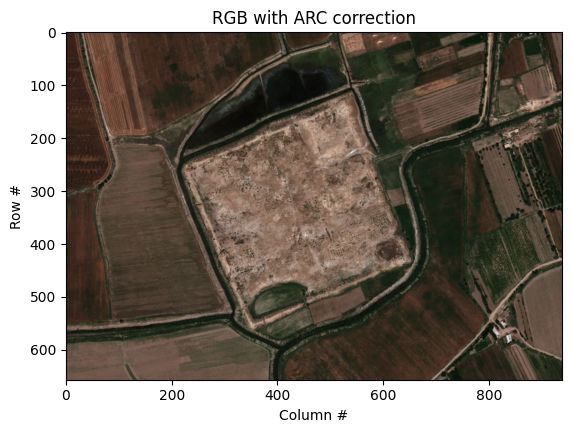

In [ ]:
plt.imshow(normalize(rgb_arc))
plt.title('RGB with ARC correction')
plt.xlabel('Column #')
plt.ylabel('Row #')

### Obtener valores de reflectividad en altura (TOA)

Los valores de reflectividad en la superficie de la atmósfera (TOA) se obtienen
aplicando la fórmula de transferencia radiativa:

$\rho(TOA)_{\lambda} = \frac{L_{\lambda} \cdot d^{2} \cdot \pi}{E_{\lambda} \cdot cos \cdot \theta_{S}}$

donde:

- $L_{\lambda}$: Radiancia del sensor en la banda $\lambda$ en $W/m^{2}/\mu/sr$.
Es el valor resultado de aplicar la corrección ARC.
- d: Distancia tierra-sol en unidades astronómicas.
- $E_{\lambda}$: *band-averaged solar exoatmospheric irradiance*. Se obtiene
del *Radiometric_Use_of_WorldView-3_v2*. Se mide en $W/m^{2}/\mu/sr$.
Se utilizan los valores de la curva de Thullier 2003, los mismos que
utiliza DigitalGlobe para calibrar las imágenes.
- $\theta_{S}$: Ángulo cenital solar, derivado del promedio del ángulo de
elevación solar (*meanSunEl*): $\theta_{S} = 90.0 - meanSunEl$. En el fichero
IMD se encuentra el valor *meanSunEl* en grados.

Al aplicar la fórmula se obtienen valores de reflectividad a techo de la atmósfera (TOA). Las mediciones contienen la reflectividad reflejada por la atmósfera.

![Composición de colore real (bandas 4-3-2) de una imagen Sentinel-2B con valores de reflectividad top-of-atmosphere (TOA) (izquierda) y reflectividad en superficie (BOA) tras la corrección atmosférica (derecha). La imagen fue adquirida en noviembre 17, 2017 sobre EEUU.](https://hls.gsfc.nasa.gov/algorithms/atmospheric-correction/)

## Corrección atmosférica

### *Cosine of the Solar zenith angle (Tz)* (COST)

El método COST (Chavez, 1996), utiliza el parámetro $L_{haze}$ (igual que DOS) y
plantea dos propuestas para obtener el efecto multiplicativo de la transmisividad.
La primera iguala el efecto de la transmisividad que afecta al rayo incidente (TAUz)
y la transmisividad de la atmósfera para el flujo ascendente (TAUv) mediante
las siguientes expresiones:

$TAUz = e^{-( AOD \cdot sec\theta_{S} )}$

$TAUv = e^{-( AOD \cdot sec\theta_{V} )}$

siendo $AOD$ el espesor óptico de la atmósfera.

La segunda, que ha sido el método aplicado por disponer del dato de $AOD$, asocia
el efecto multiplicativo de $TAUz$ con el coseno del ángulo cenital solar ($Tz$)
y $TAUv$ con el coseno del ángulo de observación.

$TAUz = 1 - \frac{TZ^{2}}{2!} + \frac{TZ^{4}}{4!} - \frac{TZ^{6}}{6!}$

Siendo $TZ$ el ángulo cenital solar **en radianes** y $!$ la representación del
factorial.

*Nota:* El factorial de un entero positivo *n*, expresado como $n!$, es el producto
de todos los enteros positivos menores o iguales a *n*.

La ecuación del método COST añade a la ecuación de transferencia radiativa
el parámetro $TAUz$, y asimila $TAUv$ a 1.

Al aplicar este método se aceptan las siguientes asunciones:

1. Existe un objeto oscuro dentro de la imagen
2. La señal atmosférica es homogénea en toda la imagen
3. **El coseno del ángulo cenital solar representa una aproximación
aceptable de la transmisividad atmosférica**.
4. *Edown* es 0 (se ignora)
5. Parámetro Lhaze se corresponde con el valor derivado
de los píxeles oscuros en la imagen (igual que en DOS)

In [ ]:
import math
from datetime import datetime

def earthsun(UTCtime):

  julianDay = juliano(UTCtime)
  # Ecuations from U.S. Naval Observatory
  D = julianDay - 2451545.0
  g = 357.529 + 0.98560028 * D
  # Convert degrees to radians
  g = math.radians(g)
  d = 1.00014 - 0.01671 * math.cos(g) - 0.00014 * math.cos(2*g)

  return(d)

# Calculate julian day from datetime python object
def juliano(UTC):

    # Convert a string with UTC into a python datetime
    date = datetime.strptime(
        UTC,
        "%Y-%m-%dT%H:%M:%S.%fZ"
    )

    # Guardar informacion
    year = date.year
    month = date.month
    day = date.day
    hours = date.hour
    minutes = date.minute
    seconds = date.second
    microseconds = date.microsecond
    # Group seconds with microseconds
    seconds = float(str(seconds) + "." + str(microseconds))

    # Calculate Universal Time
    UT = hours + (minutes/60.0) + (seconds / 3600.0)

    if(month == 1 or month == 2):
        year -= 1
        month += 12

    # Compute julian day
    A = int(year/100)
    B = 2 - A + int(A/4)
    JD_year = int(365.25 * (year + 4716))
    JD_month = int(30.6001 * (month + 1))
    JD = JD_year + JD_month + day + (UT/24.0) + B - 1524.5

    return(JD)

def convertCOST(band, band_key, adj_factors):
    """
    """
    # Return image metadata (by band)
    acf = adj_factors[band_key]['absCalFactor']
    ebw = adj_factors[band_key]['effectiveBandwidth']
    gain = adj_factors[band_key]['GAIN']
    offset = adj_factors[band_key]['OFFSET']
    E = adj_factors[band_key]['E_Thuillier']

    # Parametros comunes para todas las bandas
    meanSunEl = 71.6
    earliestAcqTime = '2017-05-29T06:43:46.705884Z'
    # Calcular el ang. cenital solar
    d = earthsun(earliestAcqTime) # Distancia tierra-sol
    cenSolAng = round(90 - float(meanSunEl), 2)

    # ND min
    Lmin = band.min()
    # Radiance from dark object (L1%)
    Lone = (0.01 * float(E) * abs(math.cos(cenSolAng))) / (d**2 * math.pi)
    # PATH RADIANCE (Lhaze)
    Lhaze = Lmin - Lone

    # Compute TAUz
    TZ = math.radians(cenSolAng)
    TAUz = 1 - (TZ**2/2) + (TZ**4/(4*3*2)) - (TZ**6/(6*5*4*3*2))

    cost = ( math.pi * (band - Lhaze) * (d**2) ) / ( E * abs(math.cos(cenSolAng)) * TAUz )

    return cost

In [ ]:
blue_cost = convertCOST(blue_arc, 'B', adj_factors)
green_cost = convertCOST(green_arc, 'G', adj_factors)
red_cost = convertCOST(red_arc, 'R', adj_factors)

print(red_cost)

[[0.10716943 0.10659765 0.10659765 ... 0.19979762 0.20151296 0.20322827]
 [0.10774119 0.10716943 0.10774119 ... 0.19236451 0.19808228 0.2055154 ]
 [0.11174367 0.10888477 0.10716943 ... 0.19407983 0.20094119 0.20094119]
 ...
 [0.21866633 0.21866633 0.2163792  ... 0.06142712 0.06371423 0.06771669]
 [0.21866633 0.21466386 0.21294853 ... 0.06485778 0.06085534 0.0728627 ]
 [0.22438411 0.22038166 0.21352032 ... 0.06771669 0.06485778 0.07229091]]


In [ ]:
print('Valores convertidos (ARC): ', red_arc[:1,:4])
print('Valores corregidos (COST): ', red_cost[:1,:4])

Valores convertidos (ARC):  [[55.367714 55.135265 55.135265 54.902817]]
Valores corregidos (COST):  [[0.10716943 0.10659765 0.10659765 0.10602588]]


In [ ]:
# Normalizar para su representacion
rgb_cost = np.dstack((normalize(red_cost), normalize(green_cost), normalize(blue_cost)))

Text(0, 0.5, 'Row #')

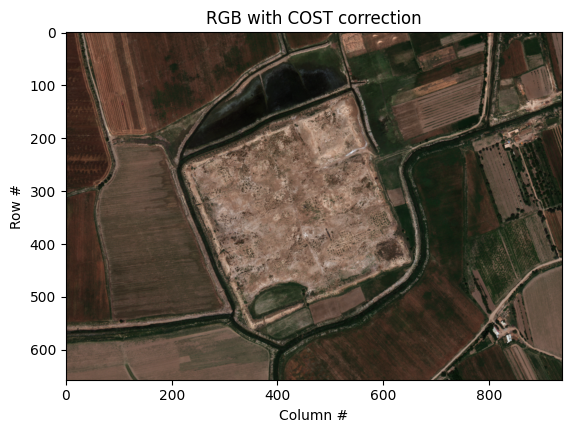

In [ ]:
plt.imshow(normalize(rgb_cost))
plt.title('RGB with COST correction')
plt.xlabel('Column #')
plt.ylabel('Row #')

## Pansharpening

A la hora de realizar el Pansharpening se debe contar con una banda PAN y varias bandas MUL cuya resolución se quiere aumentar a la de la primera.

En el momento de tomar la informacion por los sensores, la tierra está girando sobre su eje. Los píxeles de una imagen no siempre representan la misma zona en todas las bandas. Para corregir estos errores de desplazamiento, se realiza un proceso llamado *band registration*. Los productos descargados de WV3 ya llevan este pretratamiento. Los errores entre bandas una vez realizado el proceso son de entre -0.09 (−0.07 pixel) to 0.24 meter (0.19 pixel). Los valores de Sentinel-2  son de entre −21.10- (−2.11 pixels) a 28.23-meter (2.82 pixels).

## Realce de la imagen

Para poder representar la imagen correctamente es necesario aplicar un realce, es decir, establecer un nuevo máximo y mínimo.

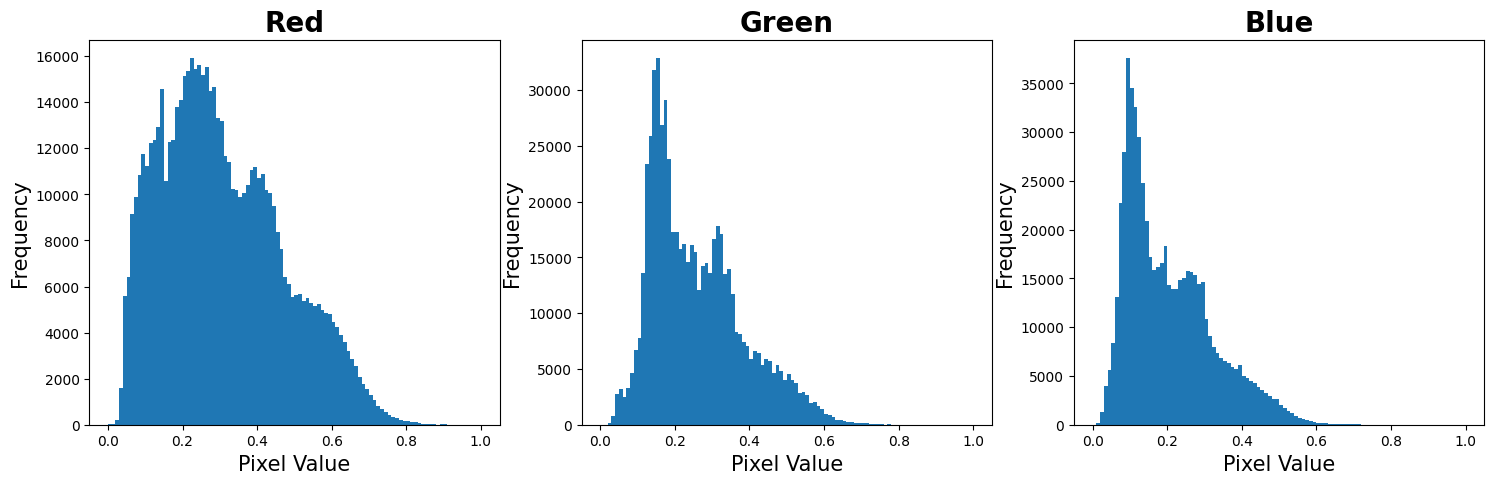

In [ ]:
#Display histograms of pixel intesity for each band
fig, axs = plt.subplots(1,3,figsize=(18,5))
fig.patch.set_facecolor('xkcd:white')

labels = ['Red','Green','Blue']
for i,ax in enumerate(axs):
    ax.hist(rgb_cost[:,:,i].flatten(),bins=100)
    ax.set_title(labels[i],size=20,fontweight="bold")
    ax.set_xlabel("Pixel Value",size=15)
    ax.set_ylabel("Frequency",size =15)

In [ ]:
red = normalize(np.clip(rgb[:,:,0], 90, 700))
green = normalize(np.clip(rgb[:,:,1], 80, 500))
blue = normalize(np.clip(rgb[:,:,2], 50, 400))

rgb_n = np.dstack((red,green,blue))

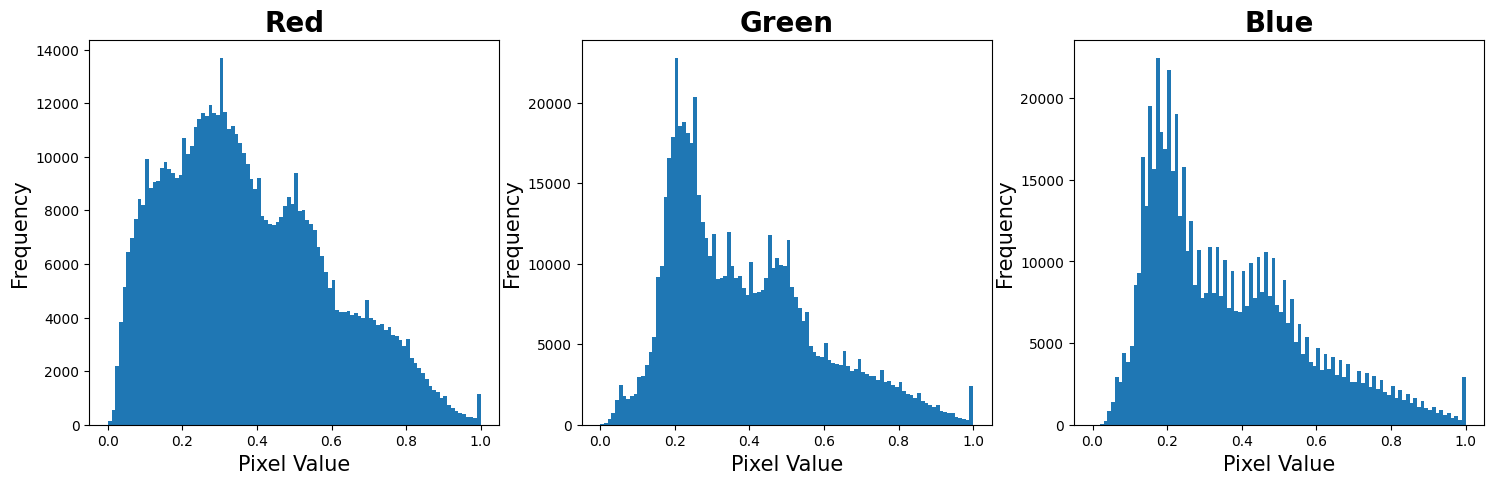

In [ ]:
#Display histograms of pixel intesity for each band
fig, axs = plt.subplots(1,3,figsize=(18,5))
fig.patch.set_facecolor('xkcd:white')

labels = ['Red','Green','Blue']
for i,ax in enumerate(axs):
    ax.hist(rgb_n[:,:,i].flatten(),bins=100)
    ax.set_title(labels[i],size=20,fontweight="bold")
    ax.set_xlabel("Pixel Value",size=15)
    ax.set_ylabel("Frequency",size =15)

Text(0, 0.5, 'Row #')

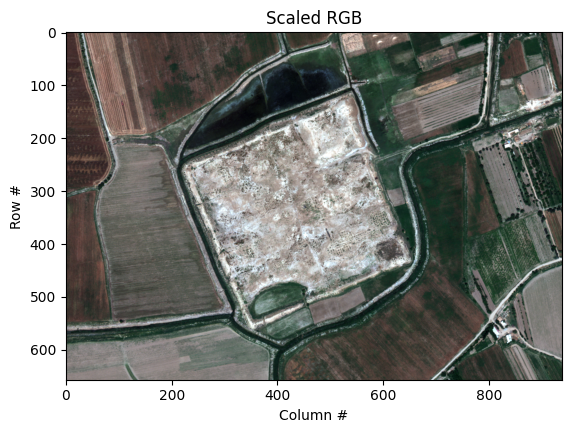

In [ ]:
plt.imshow(rgb_n)
plt.title('Scaled RGB')
plt.xlabel('Column #')
plt.ylabel('Row #')

## Conclusiones

Satellite imagery is much more than just taking a picture. Each pixel has a numeric representation of the amount of energy reflected in a range of wavelengths. And this information can be used to make numerous measurements and analytical inferences.

## Referencias

Kuchkorov, T., Urmanov, S., Kuvvatova, M., & Anvarov, I. (2020). Satellite image formation and preprocessing methods. 2020 International Conference on Information Science and Communications Technologies (ICISCT), 1-4. https://doi.org/10.1109/ICISCT50599.2020.9351456

Flujo de trabajo con GDAL: https://github.com/neerubhai/GDAL-rasterio-tutorials/blob/master/Tutorial%201%20-%20Calculate%20NDVI%20Index.ipynb